In [5]:
%matplotlib notebook
import os
os.chdir('mmpose')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"#要加上这一句话，不然我的终端服务器就会崩溃

In [6]:
import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch

import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

from mmdet.apis import inference_detector, init_detector

E:\20jiaoji\Anaconda\envs\open-mmlab\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


In [8]:
img_path = '../tests/data/coco/000000196141.jpg'

In [9]:
os.getcwd()

'E:\\20jiaoji\\mmpose\\mmpose'

In [10]:

# Faster R CNN
detector = init_detector(
    '../demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py',
    'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth',
    device=device
)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


In [11]:
pose_estimator = init_pose_estimator(
    '../configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py',
    'https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth',
    device=device,
    cfg_options={'model': {'test_cfg': {'output_heatmaps': True}}}
    #设置模型的配置选项。在这段代码中，使用了output_heatmaps: True的配置选项，表示在推断时模型会生成姿态热图（heatmaps），用于可视化人体关键点。
)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth


E:\20jiaoji\mmpose\mmpose\datasets\datasets\utils.py:102: UserWarning: The metainfo config file "configs/_base_/datasets/coco.py" does not exist. A matched config file "E:\20jiaoji\mmpose\mmpose\.mim\configs\_base_\datasets\coco.py" will be used instead.
  warnings.warn(


In [12]:
init_default_scope(detector.cfg.get('default_scope', 'mmdet'))

07/13 09:46:22 - mmengine - WARNING - The current default scope "mmpose" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".


In [13]:
detect_result = inference_detector(detector, img_path)

In [14]:
detect_result.keys()

['gt_instances', 'ignored_instances', 'pred_instances']

In [15]:
detect_result.gt_instances.labels

tensor([], device='cuda:0', dtype=torch.int64)

In [16]:
detect_result.ignored_instances.labels

tensor([], device='cuda:0', dtype=torch.int64)

In [17]:
detect_result.pred_instances.labels

tensor([ 0,  0,  0, 35,  0, 34, 32,  2,  0,  2, 35,  2,  2,  2, 34,  2,  2,  2,
         2,  0,  0,  2,  2,  7,  2,  2,  2,  0,  7,  2,  2,  2, 34,  2,  2,  2,
         0,  2, 32,  2,  2, 13,  2,  2,  2,  0,  2,  2,  2, 24, 24,  2,  2,  2,
         2,  0,  0], device='cuda:0')

In [18]:
detect_result.pred_instances.scores


tensor([0.9993, 0.9989, 0.9972, 0.9963, 0.9948, 0.9895, 0.9663, 0.9639, 0.9444,
        0.9021, 0.8993, 0.6721, 0.6328, 0.5883, 0.4565, 0.4390, 0.3992, 0.3057,
        0.2793, 0.2672, 0.2548, 0.2487, 0.2467, 0.2377, 0.2200, 0.2147, 0.1954,
        0.1861, 0.1804, 0.1674, 0.1648, 0.1413, 0.1390, 0.1270, 0.1265, 0.1240,
        0.1168, 0.1135, 0.1110, 0.0950, 0.0884, 0.0881, 0.0809, 0.0776, 0.0726,
        0.0706, 0.0698, 0.0698, 0.0666, 0.0625, 0.0616, 0.0587, 0.0575, 0.0559,
        0.0552, 0.0537, 0.0503], device='cuda:0')

In [22]:
CONF_THRES = 0.5

In [23]:
pred_instance = detect_result.pred_instances.cpu().numpy()
bboxes = np.concatenate((pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
bboxes = bboxes[np.logical_and(pred_instance.labels == 0, pred_instance.scores > CONF_THRES)]
bboxes = bboxes[nms(bboxes, 0.3)][:, :4]#非极大值抑制（NMS）算法

In [24]:
bboxes#bboxes 数组的每一行表示一个预测框
#每一行代表一个预测框，包含了左上角和右下角的坐标。
#
#对于每个预测框，坐标信息按照以下顺序排列：
#
#第一列是左上角的 x 坐标。
#第二列是左上角的 y 坐标。
#第三列是右下角的 x 坐标。
#第四列是右下角的 y 坐标。

array([[245.30547 ,  72.335014, 411.15247 , 375.06885 ],
       [450.4579  , 204.47227 , 632.55    , 419.32248 ],
       [ 35.060253,  68.71662 ,  68.9977  , 163.75905 ],
       [550.7635  ,  98.85652 , 604.0667  , 216.21509 ],
       [440.20047 ,  71.522194, 458.26596 , 105.71895 ]], dtype=float32)

In [25]:
pose_results = inference_topdown(pose_estimator, img_path, bboxes)#根据前面detector得出的对象，进行每一个预测框内topdown的骨骼识别

07/13 10:02:00 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".


In [26]:
len(pose_results)

5

In [27]:
# 把多个bbox的pose结果打包到一起
data_samples = merge_data_samples(pose_results)

In [28]:
data_samples.keys()

['gt_instances', '_pred_heatmaps', 'pred_fields', 'pred_instances']

In [29]:
data_samples.pred_instances.keypoints.shape

(5, 17, 2)

In [31]:
# 索引为 0 的人，每个关键点的坐标
data_samples.pred_instances.keypoints[0,:,:]
len(data_samples.pred_instances.keypoints[0,:,:])

17

In [35]:
# 每一类关键点的预测热力图
data_samples.pred_fields.heatmaps.shape

(17, 429, 640)

In [33]:

idx_point = 13
heatmap = data_samples.pred_fields.heatmaps[idx_point,:,:]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00012781, 0.00012781,
        0.00012781],
       [0.        , 0.        , 0.        , ..., 0.00012781, 0.00012781,
        0.00012781],
       [0.        , 0.        , 0.        , ..., 0.00012781, 0.00012781,
        0.00012781]], dtype=float32)

In [24]:
heatmap.shape

(429, 640)

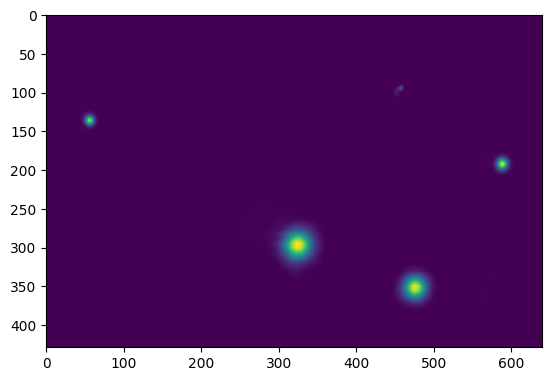

In [25]:
# 索引为 idx 的关键点，在全图上的预测热力图
plt.imshow(heatmap)
plt.show()

In [41]:
# 半径
pose_estimator.cfg.visualizer.radius = 10
# 线宽
pose_estimator.cfg.visualizer.line_width = 8
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# 元数据
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

In [42]:
img = mmcv.imread(img_path)
img = mmcv.imconvert(img, 'bgr', 'rgb')

img_output = visualizer.add_datasample(
            'result',
            img,
            data_sample=data_samples,
            draw_gt=False,
            draw_heatmap=True,
            draw_bbox=True,
            show_kpt_idx=True,
            show=False,
            wait_time=0,
            out_file='outputs/B2.jpg'
)

In [43]:
img_output.shape

(858, 640, 3)

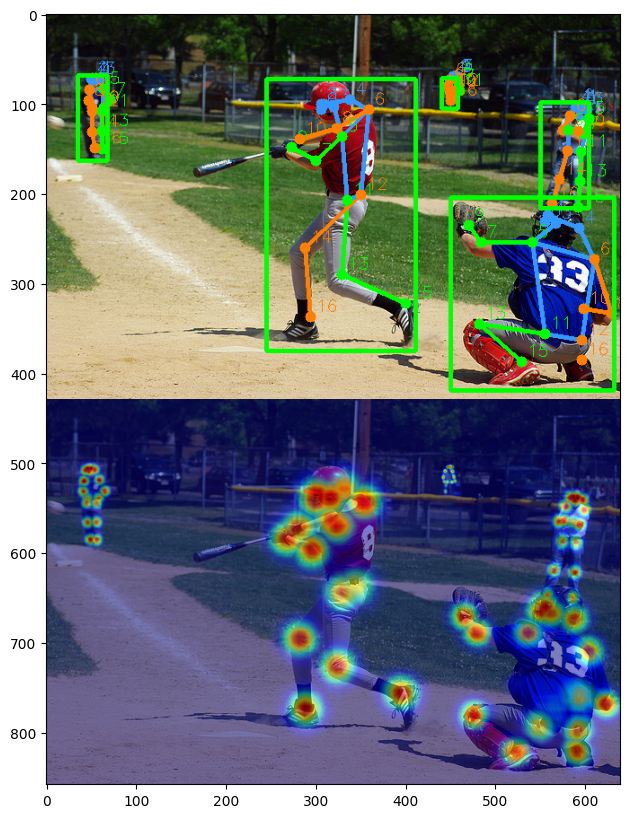

In [45]:
plt.figure(figsize=(10,10))
plt.imshow(img_output)
plt.show()